<a href="https://colab.research.google.com/github/joalissonborges94/developercielo.github.io/blob/master/TechChallenge_EGC_MERGED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Relatório Técnico: Sistema de Apoio ao Diagnóstico de ECG

**Autores:** [Joalisson dos Santos Borges]
            [Luis Gustavo Santini]
            [Marina Souza Lucas]
           [Ivna Cavalcante Barros Meireles]
           [Diego Santos via]
           
**Projeto:** Tech Challenge IADT - Fase 1

---

# Sumário Executivo

**Problema**: Um hospital universitário enfrenta o desafio de otimizar a análise de um volume crescente de exames de Eletrocardiograma (ECG). A necessidade é de uma ferramenta inteligente que possa realizar uma triagem inicial, classificando os exames como saudáveis ou potencialmente não saudáveis, a fim de apoiar a decisão clínica e priorizar casos.

**Solução Proposta**: Este relatório detalha o desenvolvimento de um modelo de Machine Learning para a classificação binária de ECGs. Utilizando um dataset público, construímos um pipeline que abrange desde o pré-processamento dos dados brutos até o treinamento e a avaliação de modelos baseados em árvores de decisão.

**Resultados:** O modelo final, um RandomForestClassifier, alcançou uma acurácia de aproximadamente 94% no conjunto de teste e um recall de 97% para a classe “Doente” (1). Isso significa que o modelo conseguiu identificar quase todos os exames com alguma alteração cardíaca, reduzindo bastante o número de falsos negativos. Como efeito colateral, houve um pequeno aumento de falsos positivos (alguns exames saudáveis classificados como doentes), o que é aceitável para um cenário de triagem, onde errar “para mais” é melhor do que deixar um caso patológico passar despercebido.

# Classificação de Sinais de ECG com Modelos Baseados em Árvore

**Objetivo:**
Construir um modelo de Machine Learning capaz de classificar exames de Eletrocardiograma (ECG) como Saudáveis ou Não Saudáveis, a partir de suas características.

**Contexto:**
Será utilizado um dataset público de ECGs para treinar e avaliar modelos supervisionados, com foco em algoritmos baseados em árvores, como DecisionTreeClassifier e RandomForestClassifier. O notebook segue um fluxo simples e didático — adequado para uma primeira versão de sistema de triagem automatizada.

**Etapas:**

Pré-processamento dos Dados – Construção do dataset final e criação da variável-alvo.

Análise Exploratória (EDA) – Compreensão da estrutura dos dados e padrões relevantes.

Modelagem e Avaliação – Treinamento, teste e análise dos modelos.

Interpretação dos Resultados – Identificação das principais features para a classificação.

# 1 - Introdução e Justificativa

**Introdução:** Este projeto apresenta o desenvolvimento de um modelo de Machine Learning para a classificação binária de exames de Eletrocardiograma (ECG). O objetivo central é utilizar informações extraídas dos registros de ECG para distinguir entre dois grupos clínicos:

Não-Doente (0): Registros considerados normais.

Doente (1): Presença de qualquer anormalidade cardíaca clinicamente relevante.

Essa classificação inicial tem como propósito apoiar o processo de triagem, funcionando como um primeiro filtro para identificar exames que podem demandar maior atenção de um profissional de saúde.

**Justificativa:** A aplicação de Machine Learning nesse contexto é motivada pelo crescente volume de exames realizados em ambientes clínicos e pela necessidade de ferramentas que ofereçam maior agilidade ao processo de interpretação. Ao automatizar a triagem, é possível direcionar com mais eficiência a atenção dos especialistas para casos que demandam análise imediata, otimizando recursos e reduzindo o tempo de resposta.

O conjunto de dados utilizado apresenta características que exigem um cuidado especial nas etapas iniciais do projeto, como o pré-processamento (ou seja, a preparação e organização dos dados antes da modelagem). Isso ocorre porque as informações associadas aos ECGs estão distribuídas em diferentes arquivos e incluem um grande número de variáveis numéricas. Dessa forma, torna-se essencial adotar um processo estruturado para consolidar os dados, definir a variável-alvo e dar suporte ao desenvolvimento do classificador.

# 2 - Carregamento dos Dados

Nesta seção, realizamos o carregamento inicial dos dados que serão utilizados ao longo do projeto. Incluímos a importação das bibliotecas essenciais e a leitura dos arquivos brutos do dataset PTB-XL, que servirão como base para as etapas subsequentes de pré-processamento e análise. O objetivo aqui é deixar os dados disponíveis no ambiente e garantir que estejam corretamente acessíveis antes de avançarmos para a fase de preparação e transformação.

### 2.1 - Bases de Dados Utilizadas

O conjunto de dados utilizado neste projeto foi construído a partir de três arquivos principais do dataset PTB-XL. Em conjunto, eles reúnem informações sobre os sinais de ECG, metadados dos pacientes e o mapeamento diagnóstico necessário para criação da variável-alvo binária (normal vs. com alterações).

**Características do Sinal (Features):**

* **12sl_features.csv:** contém mais de 780 medidas numéricas extraídas automaticamente dos sinais de ECG de 12 derivações. Essas features (como amplitudes, durações e ângulos) representam atributos relevantes do traçado eletrocardiográfico e são utilizadas como entrada no modelo de Machine Learning.

* **ptbxl_database.csv:** fornece informações gerais sobre os exames de ECG e metadados dos pacientes, incluindo idade, sexo e informações adicionais sobre o registro.

**Mapeamento Diagnóstico (Labels)**:

* **scp_statements.csv:** arquivo de referência que fornece o mapeamento hierárquico dos códigos de diagnóstico do PTB-XL para grupos de condições cardíacas. Esse mapeamento foi utilizado para transformar os diagnósticos originais em uma variável-alvo binária, classificando cada exame como normal ou com alterações clinicamente relevantes.

### 2.2 - Importação das bibliotecas

In [4]:
# Importação das bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast # Para converter strings em dicionários
from collections import Counter # Para contagem de itens

# Ferramentas do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuração para melhor visualização dos gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 2.3 - Importação dos arquivos CSV

In [5]:
# Montagem do ambiente Google Drive para acesso aos arquivos
from google.colab import drive
drive.mount('/content/drive')

# Definição do caminho para a pasta com os arquivos
path = '/content/drive/MyDrive/Tech Challenge I/ECG/'

# Carregamento dos dados
try:
    df_sl_features = pd.read_csv(path + '12sl_features.csv')
    df_database = pd.read_csv(path + 'ptbxl_database.csv')
    df_scp_statements = pd.read_csv(path + 'scp_statements.csv')
    print("Arquivos carregados com sucesso!")
except FileNotFoundError:
    print(f"Erro: Verifique se todos os 4 arquivos CSV estão no caminho especificado: {path}")

Mounted at /content/drive
Arquivos carregados com sucesso!


### 2.4 - Visualização inicial das bases carregadas

In [6]:
print("Dimensões (linhas, colunas):")
print(f"- 12sl_features      : {df_sl_features.shape}")
print(f"- ptbxl_database     : {df_database.shape}")
print(f"- scp_statements     : {df_scp_statements.shape}")

print("\nAmostra - 12sl_features:")
display(df_sl_features.head())

print("\nAmostra - ptbxl_database:")
display(df_database.head())

print("\nAmostra - scp_statements:")
display(df_scp_statements.head())

Dimensões (linhas, colunas):
- 12sl_features      : (21799, 783)
- ptbxl_database     : (21799, 28)
- scp_statements     : (71, 13)

Amostra - 12sl_features:


,P_Area_I,P_PeakTime_I,Q_Area_I,Q_PeakTime_I,R_Area_I,R_PeakTime_I,S_Area_I,S_PeakTime_I,QRS_Balance_I,T_Area_I,...,T+_Dur_aVF,T-_Dur_aVF,T+_Amp_aVF,T-_Amp_aVF,T_Morph_aVF,T_DurFull_aVF,P_Dur_Global,P_Found_Global,HR__Global,P_Term_V1
0,0.264,64.0,0.000,0.0,0.737,30.0,0.000,0.0,629.0,0.819,...,208.0,0.0,0.151,0.000,1,208.0,112.0,1,64.0,0.000
1,-0.047,6.0,0.015,8.0,0.794,36.0,1.246,76.0,205.0,2.206,...,0.0,127.0,0.000,-0.078,-1,127.0,66.0,1,75.0,0.000
2,0.000,0.0,0.000,0.0,0.792,38.0,1.389,74.0,141.0,1.155,...,0.0,66.0,0.000,-0.078,-1,66.0,NaN,0,169.0,0.000
3,0.196,74.0,0.000,0.0,0.947,56.0,0.000,0.0,439.0,-0.339,...,0.0,0.0,0.000,0.000,-1,0.0,114.0,1,79.0,0.000
4,0.287,102.0,0.000,0.0,1.021,36.0,0.000,0.0,937.0,0.756,...,104.0,66.0,39.000,-0.034,-2,170.0,136.0,1,92.0,6.612



Amostra - ptbxl_database:


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr



Amostra - scp_statements:


,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


# 3 - Pré-processamento e Limpeza dos Dados

Nesta etapa, iniciamos o processo de preparação dos dados para que possam ser utilizados no treinamento do modelo de Machine Learning. O objetivo do pré-processamento é transformar os dados brutos carregados anteriormente em um formato consistente, estruturado e adequado para análise e modelagem.

Serão realizadas atividades como consolidação das bases, criação da variável-alvo, tratamento de valores ausentes, ajustes de tipos de dados e, quando apropriado, padronização das variáveis. Essas ações são fundamentais para garantir a qualidade do dataset e evitar que inconsistências, ruídos ou informações irrelevantes prejudiquem o desempenho do modelo.

### 3.1 Consolidação da Base

Nesta etapa, unificamos as tabelas necessárias para compor a base estrutural do projeto, ainda sem o rótulo.

* **ptbxl_database:** alguns metadados importantes do paciente
* **12sl_features:** features da eletrocardiografia





In [62]:
# Garante que o DataFrame tenha 'ecg_id' como índice.
# Se 'ecg_id' estiver como coluna, converte para índice.
def _ensure_index_ecgid(df: pd.DataFrame, df_name: str) -> pd.DataFrame:
    if df.index.name != 'ecg_id':
        if 'ecg_id' in df.columns:
            df = df.set_index('ecg_id')
        else:
            raise ValueError(f"{df_name}: 'ecg_id' não encontrado como índice ou coluna.")

    if df.index.duplicated().any():
        raise ValueError(f"{df_name}: existem valores duplicados de 'ecg_id'.")

    return df

# Une Metadados + Features por 'ecg_id' (inner join).
# Não inclui a coluna 'Doente' nesta etapa — ela será anexada mais a frente.
def merge_metadata_and_features(metadata_df, features_df, save_path=None):
    print("Iniciando a consolidação de Metadados e Features...")

    metadata_df = _ensure_index_ecgid(metadata_df, "df_database")
    features_df = _ensure_index_ecgid(features_df, "df_sl_features")

    # Merge (inner) por índice
    df_base = metadata_df.join(features_df, how='inner')

    print("Consolidação concluída com sucesso.")
    print(f"Shape final da base (linhas, colunas): {df_base.shape}")

    if save_path is not None:
        df_base.to_csv(save_path, index=True)
        print(f"Base consolidada salva em: {save_path}")

    return df_base


df_base = merge_metadata_and_features(
    metadata_df=df_database,            # Metadados
    features_df=df_sl_features,         # Features 12SL
)

print("\nPrévia da Base Consolidada:")
display(df_base.head())

Iniciando a consolidação de Metadados e Features...
Consolidação concluída com sucesso.
Shape final da base (linhas, colunas): (21799, 816)

Prévia da Base Consolidada:


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,T+_Dur_aVF,T-_Dur_aVF,T+_Amp_aVF,T-_Amp_aVF,T_Morph_aVF,T_DurFull_aVF,P_Dur_Global,P_Found_Global,HR__Global,P_Term_V1
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,208.0,0.0,0.151,0.0,1,208.0,112.0,1,64.0,0.000
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,166.0,0.0,0.249,0.0,1,166.0,108.0,1,47.0,4.002
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,240.0,0.0,0.063,0.0,1,240.0,92.0,1,64.0,0.000
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,161.0,0.0,0.400,0.0,1,161.0,114.0,1,75.0,2.880
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,194.0,0.0,0.380,0.0,1,194.0,114.0,1,66.0,0.000


### 3.2 - Construção da Variável-Alvo (Target)

Antes de prosseguir com a análise exploratória, é necessário definir a variável-alvo (target) que será utilizada no treinamento do modelo de Machine Learning. Os exames de ECG do PTB-XL possuem diagnósticos originalmente registrados em subclasses (códigos SCP), que representam condições cardíacas específicas. Para tornar o problema adequado a uma tarefa de classificação binária, essas subclasses foram agrupadas em superclasses (categorias diagnósticas mais amplas), o que simplifica a interpretação e possibilita a criação de um indicador clínico mais direto.

Cada ECG do PTB-XL possui anotações SCP-ECG agregadas em cinco superclasses diagnósticas principais: NORM, MI, STTC, CD e HYP, conforme o arquivo scp_statements.csv. Para o objetivo de triagem binária, foi definido Doente = 1 quando o exame apresenta qualquer superclasse patológica entre {MI, STTC, CD, HYP} e Saudável = 0 quando o exame apresenta NORM e nenhuma superclasse patológica. Essa abordagem prioriza a sensibilidade na identificação de anormalidades cardíacas e é coerente com a estrutura hierárquica do conjunto de dados.

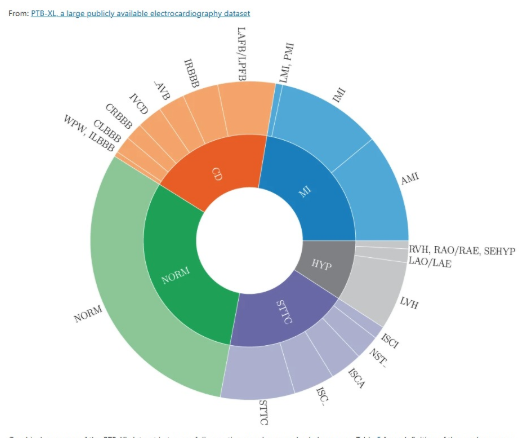

Com base nesse agrupamento, foi definida a regra para classificação binária, atribuindo a cada exame a condição de “Doente” ou “Não-Doente”:

Doente (1): atribuído quando o exame apresenta ao menos uma das seguintes superclasses patológicas:

MI – Infarto do Miocárdio

STTC – Alterações de Segmento ST e Onda T

CD – Distúrbios de Condução

HYP – Hipertrofia

Não-Doente (0): atribuído apenas aos exames pertencentes exclusivamente à superclass NORM, que representa registros considerados normais.

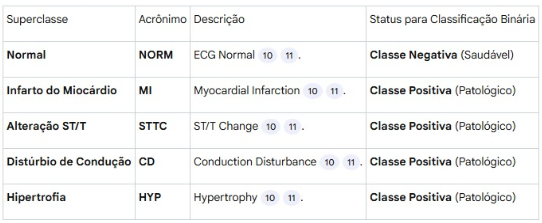

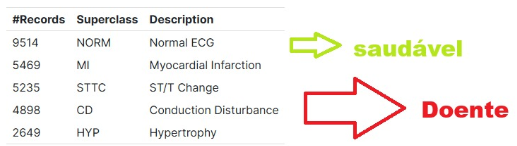

Essa transformação permite consolidar múltiplos diagnósticos possíveis em um único indicador clínico relevante para um cenário de triagem, facilitando o treinamento e a avaliação do classificador.

In [81]:
import ast
import pandas as pd

# 1) Preparar o dicionário de mapeamento (scp_statements → superclasses)
scp_df = df_scp_statements.copy()
scp_df["diagnostic"] = pd.to_numeric(scp_df["diagnostic"], errors="coerce")
scp_df = scp_df[scp_df["diagnostic"] == 1]

# usar o código SCP como índice
if scp_df.index.name is None:
    scp_df = scp_df.set_index(scp_df.columns[0])

# dicionário oficial: {scp_code -> diagnostic_class}  (NORM, MI, STTC, CD, HYP)
scp_map = dict(zip(scp_df.index, scp_df["diagnostic_class"]))

# 2) Normalizar scp_codes do ptbxl_database
df_database["scp_codes"] = df_database["scp_codes"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# 3) Mapear cada exame para as superclasses oficiais
def map_to_official_superclasses(scp_dict):
    if not isinstance(scp_dict, dict):
        return []
    mapped = []
    for code in scp_dict.keys():
        if code in scp_map:
            mapped.append(scp_map[code])
    return list(set(mapped))  # remove duplicatas

df_database["diagnostic_superclass"] = df_database["scp_codes"].apply(
    map_to_official_superclasses
)

# 4) Criar a variável binária "Doente"
def make_label_official(superclasses):
    # 0 = só NORM
    if superclasses and "NORM" in superclasses and len(superclasses) == 1:
        return 0
    # 1 = qualquer classe patológica
    if any(cls in ("MI", "STTC", "CD", "HYP") for cls in (superclasses or [])):
        return 1
    # registros sem classe (vamos inspecionar na 3.3)
    return None

df_database["Doente"] = df_database["diagnostic_superclass"].apply(
    make_label_official
)

# 5) Integrar com o dataset consolidado da etapa 3.1 (se já existir)
if "df_base" in globals():
    if df_base.index.name != "ecg_id" and "ecg_id" in df_base.columns:
        df_base = df_base.set_index("ecg_id")
    if df_database.index.name != "ecg_id" and "ecg_id" in df_database.columns:
        df_database = df_database.set_index("ecg_id")

    df_final = df_base.join(df_database[["Doente"]], how="inner")
    print("df_final criado com sucesso.")
    print("Shape:", df_final.shape)
else:
    print("Aviso: df_base ainda não existe. Target criado apenas em df_database.")


df_final criado com sucesso.
Shape: (21799, 816)


### 3.3 – Validação da Construção da Variável-Alvo (Target)

Após o mapeamento das subclasses SCP para as superclasses oficiais do PTB-XL (**NORM, MI, STTC, CD e HYP**) e da criação da variável binária **Doente**, é necessário verificar se o processo foi aplicado de forma consistente ao conjunto de dados.

Os objetivos desta etapa são:
* Confirmar que todos os exames receberam uma classificação (ou identificar claramente os casos sem mapeamento);
* Avaliar a distribuição final da variável-alvo (**0 = Saudável, 1 = Doente**) para checar se ela está coerente com a característica original do dataset, que possui maior volume de exames normais.



In [84]:
print("Validação da variável 'Doente'\n")

total_registros = len(df_database)
print(f"Total de exames no dataset: {total_registros}\n")

# 1) exames sem nenhuma superclasse
num_sem_superclasse = df_database["diagnostic_superclass"].apply(lambda x: len(x or []) == 0).sum()
print(f"Exames sem superclasse identificada: {num_sem_superclasse}")

if num_sem_superclasse > 0:
    print("Amostra dos exames sem superclasse:")
    display(df_database.loc[df_database["diagnostic_superclass"].apply(lambda x: len(x or []) == 0), ["scp_codes"]].head())

# 2) contagem obtida de cada superclasse (com base no mapeamento oficial)
superclasses = ["NORM", "MI", "STTC", "CD", "HYP"]
contagem_obtida = {cls: 0 for cls in superclasses}

for sc_list in df_database["diagnostic_superclass"]:
    for cls in sc_list:
        if cls in contagem_obtida:
            contagem_obtida[cls] += 1

print("\nContagem obtida (por superclasse):")
for cls, v in contagem_obtida.items():
    print(f"- {cls:<5}: {v}")

print("\nDistribuição da variável 'Doente':")
display(pd.DataFrame({
    "Quantidade": dist,
    "%": (dist / total_registros * 100).round(2)
}))

print("\nFim da validação da variável 'Doente'")


Validação da variável 'Doente'

Total de exames no dataset: 21799

Exames sem superclasse identificada: 411
Amostra dos exames sem superclasse:


,scp_codes
ecg_id,
17,"{'AFLT': 100.0, 'ABQRS': 0.0, 'AFIB': 0.0}"
18,{'AFLT': 100.0}
20,"{'AFLT': 100.0, 'ABQRS': 0.0}"
23,{'AFLT': 100.0}
34,{'AFLT': 100.0}



Contagem obtida (por superclasse):
- NORM : 9514
- MI   : 5469
- STTC : 5235
- CD   : 4898
- HYP  : 2649

Distribuição da variável 'Doente':


,Quantidade,%
Doente,,
Doente (1),12319,56.51
Saudável (0),9069,41.60
NaN,411,1.89



Fim da validação da variável 'Doente'


# 4 – Análise Exploratória e Preparação dos Dados

### 4.1 – Visão geral do dataset

Nesta etapa faremos uma inspeção inicial do conjunto de dados já consolidado nas etapas anteriores. Nosso objetivo aqui é entender o tamanho da base, o tipo das variáveis disponíveis e se há presença de valores ausentes que possam impactar a modelagem. Como estamos trabalhando com o PTB-XL, que combina metadados (como idade e sexo) com centenas de features numéricas extraídas do ECG, essa visão geral é importante para decidir quais colunas seguirão para o modelo e quais podem ser descartadas por serem administrativas ou redundantes.

In [87]:
# escolher o dataframe base
if "df_final" in globals():
    df = df_final.copy()
    print("Usando df_final.")
elif "merged_dataframe" in globals():
    df = merged_dataframe.copy()
    print("Usando merged_dataframe.")
else:
    df = df_database.copy()
    print("Atenção: usando df_database como fallback.")

# shape
print("\nShape (linhas, colunas):", df.shape)

# tipos (amostra)
print("\nTipos das colunas (amostra):")
print(df.dtypes.head(30))

# nulos (tabela)
null_counts = df.isna().sum()
null_columns = null_counts[null_counts > 0].sort_values(ascending=False)

print("\nColunas com valores nulos (top 20):")
print(null_columns.head(20))

# colunas administrativas / de controle
possiveis_admin = [
    c for c in df.columns
    if any(x in c.lower() for x in ["filename", "path", "bucket", "recording", "strat_fold"])
]
if possiveis_admin:
    print("\nColunas possivelmente não usadas na modelagem:")
    for c in possiveis_admin:
        print("*", c)


Usando df_final.

Shape (linhas, colunas): (21799, 816)

Tipos das colunas (amostra):
patient_id                      float64
age                             float64
sex                               int64
height                          float64
weight                          float64
nurse                           float64
site                            float64
device                           object
recording_date                   object
report                           object
scp_codes                        object
heart_axis                       object
infarction_stadium1              object
infarction_stadium2              object
validated_by                    float64
second_opinion                     bool
initial_autogenerated_report       bool
validated_by_human                 bool
baseline_drift                   object
static_noise                     object
burst_noise                      object
electrodes_problems              object
extra_beats                      o

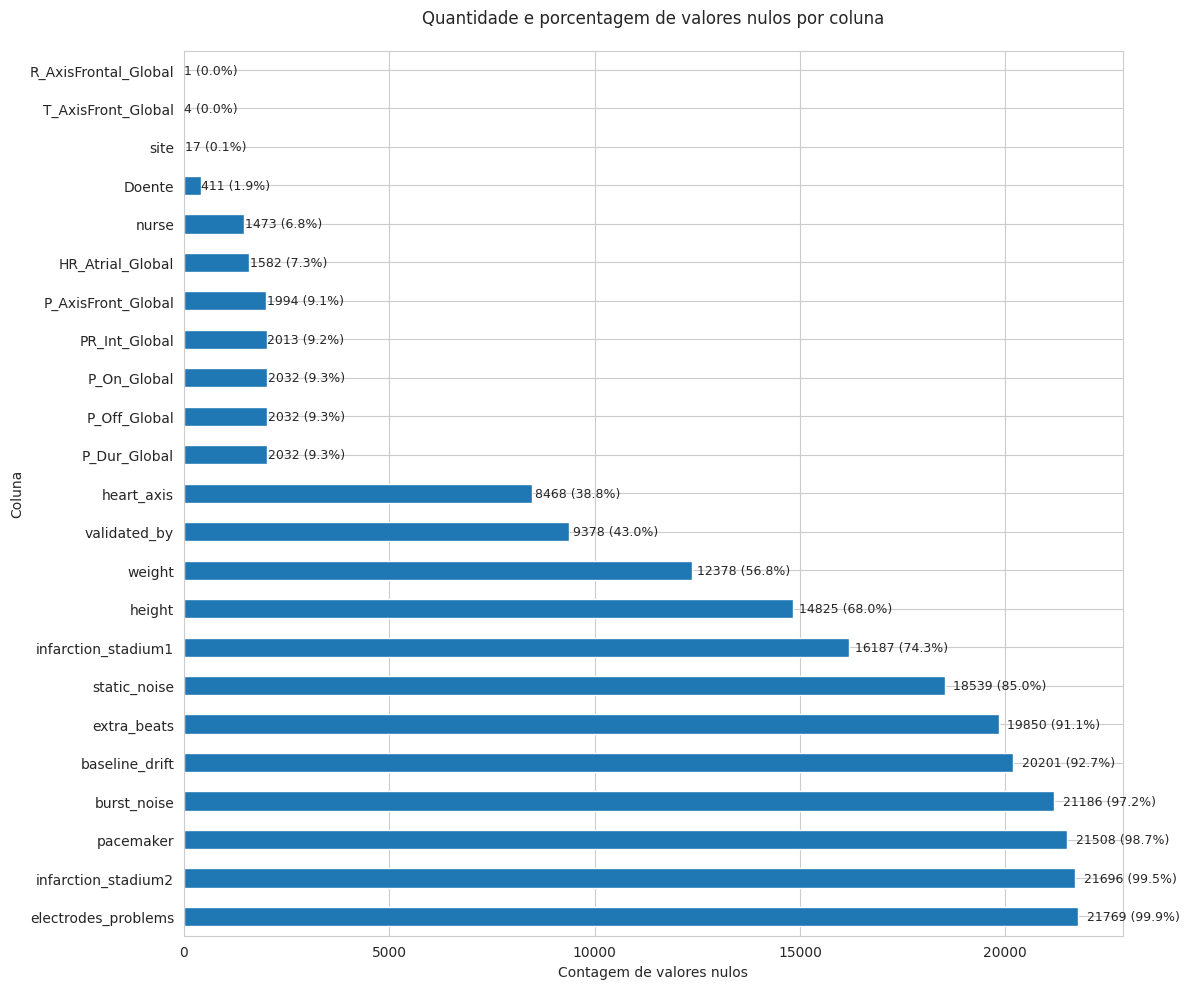

In [88]:
import matplotlib.pyplot as plt

# usa o mesmo df do bloco 1
null_columns = df.isna().sum()
null_columns = null_columns[null_columns > 0].sort_values(ascending=False)
total_rows = len(df)

if not null_columns.empty:
    plt.figure(figsize=(12, 10))
    null_columns.plot(kind="barh")

    plt.title("Quantidade e porcentagem de valores nulos por coluna", pad=20)
    plt.xlabel("Contagem de valores nulos")
    plt.ylabel("Coluna")

    for idx, value in enumerate(null_columns):
        percent = (value / total_rows) * 100
        label = f"{value} ({percent:.1f}%)"
        plt.text(value * 1.01, idx, label, va="center", fontsize=9)

    plt.tight_layout()
    # plt.savefig("grafico_valores_nulos.png", dpi=120, bbox_inches="tight")
    plt.show()
else:
    print("Não há colunas com valores nulos para plotar.")


**Observações da análise inicial**

* Algumas colunas apresentam preenchimento extremamente baixo (acima de 90% de valores nulos), como electrodes_problems, infarction_stadium2, pacemaker, burst_noise, baseline_drift, extra_beats e static_noise. Essas variáveis não têm cobertura suficiente para serem usadas na modelagem e serão removidas na etapa 4.2.

* As variáveis antropométricas (height e weight) também têm muitos valores ausentes (entre ~57% e ~68%). Elas podem ser mantidas, mas exigem imputação ou então precisam ser descartadas se quisermos trabalhar apenas com features completas.

* A coluna heart_axis tem um volume intermediário de ausentes (cerca de 39%) e deve ser avaliada caso a caso: dá para imputar, mas não é uma coluna essencial para o modelo baseado nas features numéricas do ECG.

* A variável-alvo Doente ficou sem rótulo em 411 exames (aprox. 1,9%). Esses registros não podem ir para o treinamento e serão filtrados na próxima etapa.

* Também foram identificadas colunas administrativas do PTB-XL (recording_date, strat_fold, filename_lr, filename_hr) que não agregam informação preditiva e serão removidas no tratamento.


### 4.2 – Tratamento inicial de valores ausentes

Nesta etapa vamos deixar o dataset pronto para modelagem. Primeiro vamos remover os registros que não têm a variável-alvo (411 exames). Depois vamos excluir colunas com preenchimento muito baixo e colunas administrativas do PTB-XL. Por fim, vamos tratar os valores ausentes que sobrarem com uma imputação simples (mediana para numéricas e um valor padrão para categóricas), para que o train/test split funcione sem erro.

In [128]:
# Limpeza estrutural

# ponto de partida
if "df_final" in globals():
    df = df_final.copy()
elif "merged_dataframe" in globals():
    df = merged_dataframe.copy()
else:
    df = df_database.copy()
    print("Atenção: usando df_database como fallback.")

print("Shape inicial:", df.shape)

# 1) remover registros sem target (411 casos)
df = df.dropna(subset=["Doente"])
print("Shape após remover registros sem Doente:", df.shape)

# 2) colunas com muitos nulos (identificadas na 4.1)
numeric_columns_to_drop = [
    "electrodes_problems",
    "infarction_stadium2",
    "pacemaker",
    "burst_noise",
    "baseline_drift",
    "extra_beats",
    "static_noise",
]

# 3) colunas administrativas / que não entram no modelo
non_numeric_columns_to_drop = [
    "recording_date",
    "report",
    "device",
    "scp_codes",     # já usamos para criar o target
    "filename_lr",
    "filename_hr",
    "strat_fold",
    "second_opinion",
    "validated_by_human",
    "validated_by",
    "patient_id",
]

columns_to_drop = numeric_columns_to_drop + non_numeric_columns_to_drop
columns_to_drop = [c for c in columns_to_drop if c in df.columns]

df = df.drop(columns=columns_to_drop, errors="ignore")
print("Colunas removidas:", columns_to_drop)
print("Shape após remoção de colunas:", df.shape)

# 4) remover ecg_id se ainda existir como coluna
if "ecg_id" in df.columns:
    df = df.drop(columns=["ecg_id"])

# vamos seguir usando df a partir daqui

Shape inicial: (21799, 816)
Shape após remover registros sem Doente: (21388, 816)
Colunas removidas: ['electrodes_problems', 'infarction_stadium2', 'pacemaker', 'burst_noise', 'baseline_drift', 'extra_beats', 'static_noise', 'recording_date', 'report', 'device', 'scp_codes', 'filename_lr', 'filename_hr', 'strat_fold', 'second_opinion', 'validated_by_human', 'validated_by', 'patient_id']
Shape após remoção de colunas: (21388, 798)


In [129]:
# Tratamento de NaN

# separar alvo e preditores
X = df.drop(columns=["Doente"])
y = df["Doente"]

# remover colunas operacionais/fracas (pouco sinal ou muito específicas do local)
cols_to_drop_light = [c for c in ["heart_axis", "site", "nurse"] if c in X.columns]
X = X.drop(columns=cols_to_drop_light, errors="ignore")
print("Colunas adicionais removidas (baixa relevância):", cols_to_drop_light)

# identificar tipos
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

# imputação nas numéricas (mediana)
for col in num_cols:
    if X[col].isna().any():
        med = X[col].median()
        X[col] = X[col].fillna(med)

# imputação nas categóricas
for col in cat_cols:
    if X[col].isna().any():
        X[col] = X[col].fillna("Unknown")

print("Top 5 colunas com NaN após tratamento:")
print(X.isna().sum().sort_values(ascending=False).head(5))

# datasets prontos para modelagem
X_clean = X.copy()
y_clean = y.copy()

print("\nShapes finais:")
print("X_clean:", X_clean.shape)
print("y_clean:", y_clean.shape)

Colunas adicionais removidas (baixa relevância): ['heart_axis', 'site', 'nurse']
Top 5 colunas com NaN após tratamento:
P_Term_V1    0
age          0
sex          0
height       0
weight       0
dtype: int64

Shapes finais:
X_clean: (21388, 794)
y_clean: (21388,)


**Observações do tratamento**

* A remoção dos 411 registros sem a variável-alvo reduziu a base de 21.799 para 21.388 exames.
* As colunas com preenchimento muito baixo e as colunas administrativas do PTB-XL foram efetivamente removidas, reduzindo o número de colunas de 816 para 794.
* O conjunto final para modelagem ficou com 21.388 linhas e 794 features preditoras (X_clean), além da coluna alvo (y_clean).


### 4.3 – Análises exploratórias visuais

Antes de seguir para o treinamento dos modelos, vamos visualizar algumas informações básicas do dataset já limpo. O objetivo é confirmar o balanceamento da variável-alvo, entender o perfil dos pacientes (idade e sexo) e olhar uma correlação resumida das principais variáveis numéricas. Como o dataset possui centenas de features extraídas do ECG, vamos trabalhar aqui apenas com um subconjunto para visualização.

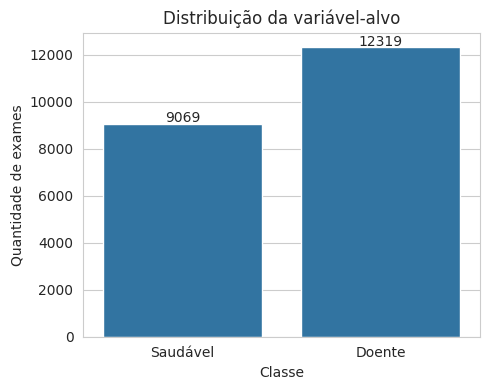

Proporção por classe:
Doente
1.0    57.6
0.0    42.4
Name: proportion, dtype: float64


In [130]:
# Distribuição da variável-alvo

import seaborn as sns
import matplotlib.pyplot as plt

target_counts = y_clean.value_counts().sort_index()

plt.figure(figsize=(5, 4))
sns.barplot(x=target_counts.index.map({0: "Saudável", 1: "Doente"}), y=target_counts.values)
plt.title("Distribuição da variável-alvo")
plt.ylabel("Quantidade de exames")
plt.xlabel("Classe")
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 50, str(v), ha="center")
plt.tight_layout()
plt.show()

print("Proporção por classe:")
print((y_clean.value_counts(normalize=True) * 100).round(2))


**Observações:** A variável-alvo ficou levemente desbalanceada após a limpeza: temos 12.319 exames classificados como Doente e 9.069 como Saudável. Não é um desbalanceamento extremo, mas vale usar split estratificado e olhar recall da classe Doente.



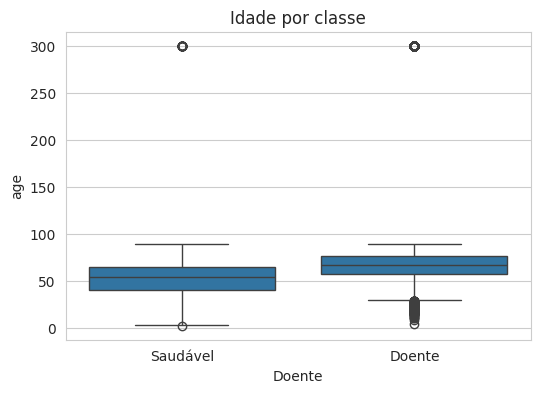

In [131]:
# Distribuição de idade por classe

df_plot = X_clean.copy()
df_plot["Doente"] = y_clean

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_plot, x="Doente", y="age")
plt.xticks([0, 1], ["Saudável", "Doente"])
plt.title("Idade por classe")
plt.show()


**Observações:** O boxplot de idade mostra que pacientes Doentes tendem a ser mais velhos do que os Saudáveis (mediana mais alta). Há alguns valores claramente fora da faixa esperada (ex.: idade próxima de 300), que devem ser tratados ou filtrados antes de modelos mais sensíveis.


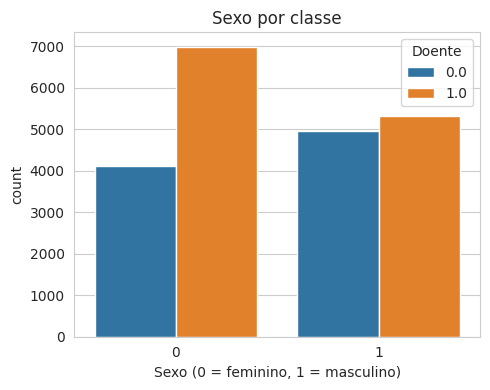

In [132]:
# Distribuição de sexo por classe
if "sex" in df_plot.columns:
    plt.figure(figsize=(5, 4))
    sns.countplot(data=df_plot, x="sex", hue="Doente")
    plt.title("Sexo por classe")
    plt.xlabel("Sexo (0 = feminino, 1 = masculino)")  #Não tenho certeza dessa info - vamos verificar
    plt.tight_layout()
    plt.show()


**Observações:**  A distribuição por sexo indica que há mais exames de pacientes do sexo feminino (0) na classe Doente. Entre os homens (1), as quantidades de Doente e Saudável ficaram mais próximas. Isso sugere que a informçaõ sobre o sexo pode ajudar um pouco, mas não deve ser a feature principal.



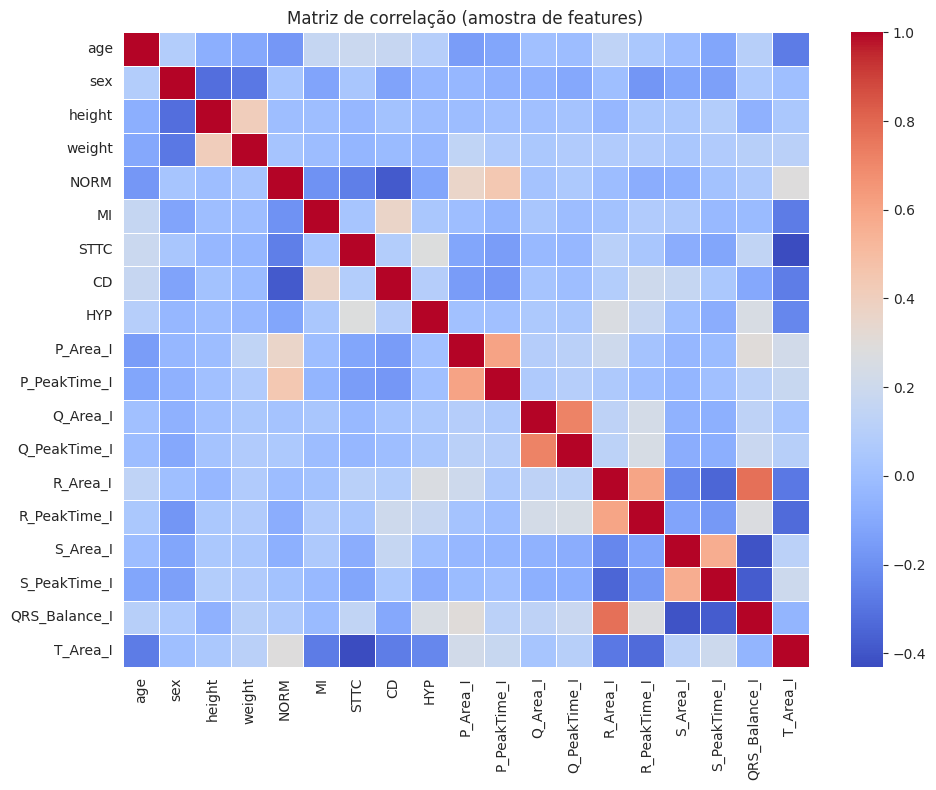

In [133]:
# Matriz de correlação (subconjunto)

# escolhe algumas colunas numéricas para visualizar
cols_base = ["age", "sex", "height", "weight"]

# Ensure only numeric columns are selected from X_clean for correlation calculation
X_clean_numeric = X_clean.select_dtypes(include=np.number)

# Get numeric feature columns excluding the base columns
num_features = [c for c in X_clean_numeric.columns if c not in cols_base]

# pega só as 15 primeiras de features numéricas para não estourar o gráfico
sample_features = num_features[:15]

# Combine base numeric columns and sample numeric features
selected_numeric_cols = [c for c in cols_base + sample_features if c in X_clean_numeric.columns]


if selected_numeric_cols:
    corr_df = X_clean_numeric[selected_numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("Matriz de correlação (amostra de features)")
    plt.tight_layout()
    plt.show()
else:
    print("No numeric columns selected for correlation plot.")

**Observações:** A matriz de correlação, feita com uma amostra de features, mostra correlações altas apenas entre medidas muito relacionadas do mesmo complexo (por exemplo, áreas e tempos do mesmo segmento). As demais variáveis (idade, sexo, altura, peso) têm baixa correlação entre si, o que favorece o uso de modelos baseados em árvore.


# 5 – Modelagem e avaliação

Nesta seção vamos treinar e avaliar modelos de classificação binária para prever a variável-alvo Doente a partir das features numéricas do ECG (12SL) e metadados selecionados. Adotaremos um fluxo simples e reprodutível: divisão estratificada em treino e teste, um modelo baseline para referência e um modelo principal mais robusto. A avaliação prioriza, além da acurácia, métricas por classe (precision, recall, F1), com ênfase no recall da classe Doente (1) por refletir o objetivo de triagem clínica.

### 5.1 – Separação em treino e teste

Nesta etapa vamos dividir o dataset tratado (X_clean e y_clean) em conjuntos de treino e teste. A divisão será estratificada para manter a mesma proporção de exames Doente e Saudável nos dois conjuntos. Isso garante uma avaliação mais fiel do modelo.

In [134]:
from sklearn.model_selection import train_test_split

# partimos do resultado da etapa 4.2
X = X_clean.copy()
y = y_clean.copy()

# split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTamanhos dos conjuntos:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

print("\nDistribuição no treino (%):")
print((y_train.value_counts(normalize=True) * 100).round(2))

print("\nDistribuição no teste (%):")
print((y_test.value_counts(normalize=True) * 100).round(2))



Tamanhos dos conjuntos:
X_train: (17110, 794)
X_test : (4278, 794)
y_train: (17110,)
y_test : (4278,)

Distribuição no treino (%):
Doente
1.0    57.6
0.0    42.4
Name: proportion, dtype: float64

Distribuição no teste (%):
Doente
1.0    57.6
0.0    42.4
Name: proportion, dtype: float64


### 5.2 – Modelo baseline (DecisionTreeClassifier)

Nesta etapa vamos treinar um modelo baseline usando uma árvore de decisão (DecisionTreeClassifier). A ideia aqui não é obter o melhor resultado possível, mas ter uma primeira referência de desempenho sobre este dataset já tratado. Esse baseline vai servir para comparar com um modelo mais robusto na sequência (Random Forest).

Vamos avaliar o modelo com acurácia, relatório de classificação e matriz de confusão, dando atenção especial ao desempenho na classe Doente (1), que é a mais importante para o cenário de triagem.

Shape numérico – treino: (17110, 791)
Shape numérico – teste : (4278, 791)
Acurácia (teste): 0.9437
ROC-AUC  (teste): 0.9426

Classification report (teste):
              precision    recall  f1-score   support

Saudável (0)     0.9319    0.9355    0.9337      1814
  Doente (1)     0.9524    0.9497    0.9510      2464

    accuracy                         0.9437      4278
   macro avg     0.9421    0.9426    0.9424      4278
weighted avg     0.9437    0.9437    0.9437      4278



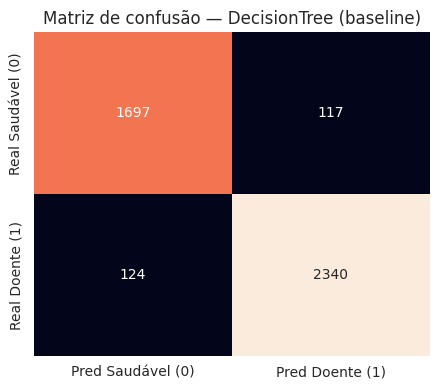

In [146]:
# Baseline com DecisionTreeClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 0) garantir que estamos só com as colunas numéricas
X_train_num = X_train.select_dtypes(include=["int64", "float64"]).copy()
X_test_num  = X_test.select_dtypes(include=["int64", "float64"]).copy()

print("Shape numérico – treino:", X_train_num.shape)
print("Shape numérico – teste :", X_test_num.shape)

# 1) Treinar o baseline
dt = DecisionTreeClassifier(
    random_state=42,
)
dt.fit(X_train_num, y_train)

# 2) Predições e probabilidades
y_pred  = dt.predict(X_test_num)
y_prob1 = dt.predict_proba(X_test_num)[:, 1]

# 3) Métricas
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob1)

print(f"Acurácia (teste): {acc:.4f}")
print(f"ROC-AUC  (teste): {auc:.4f}\n")

print("Classification report (teste):")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Saudável (0)", "Doente (1)"],
    digits=4
))

# 4) Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=["Real Saudável (0)", "Real Doente (1)"], columns=["Pred Saudável (0)", "Pred Doente (1)"])

plt.figure(figsize=(4.5, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cbar=False)
plt.title("Matriz de confusão — DecisionTree (baseline)")
plt.tight_layout()
plt.show()


**Análise do modelo**

* O modelo de árvore de decisão conseguiu um bom desempenho geral (acurácia ≈ 94%) mesmo sendo um modelo simples e treinado sem engenharia de atributos avançada. O ponto mais importante é que o recall da classe Doente (1) ficou em torno de 95%, ou seja, o modelo conseguiu identificar a maior parte dos exames que realmente tinham alguma alteração. Em contrapartida, houve um pequeno número de falsos positivos (exames saudáveis classificados como doentes), o que é aceitável para um caso de uso de apoio à triagem.

*Como este é um modelo de árvore “puro”, ele pode estar um pouco ajustado ao conjunto de treino. Na próxima etapa vamos treinar uma Random Forest para buscar mais robustez e estabilidade das métricas.


### 5.3 – Modelo principal (RandomForestClassifier)

Nesta etapa vamos treinar o modelo principal usando uma Random Forest para o mesmo problema de classificação binária. A ideia é usar exatamente o mesmo conjunto de treino e teste da etapa anterior para podermos comparar diretamente com o baseline.

Diferentemente de uma árvore única, a Random Forest combina várias árvores de decisão e, por isso, costuma ser mais estável e menos sensível a ruído. Nosso objetivo aqui é verificar se conseguimos manter (ou melhorar) o bom recall da classe Doente (1) que vimos no baseline, mas com um modelo mais robusto.

Acurácia (teste) – RF: 0.9439
ROC-AUC  (teste) – RF: 0.9868

Classification report – RF:
              precision    recall  f1-score   support

Saudável (0)     0.9570    0.9085    0.9321      1814
  Doente (1)     0.9351    0.9700    0.9522      2464

    accuracy                         0.9439      4278
   macro avg     0.9460    0.9392    0.9422      4278
weighted avg     0.9444    0.9439    0.9437      4278



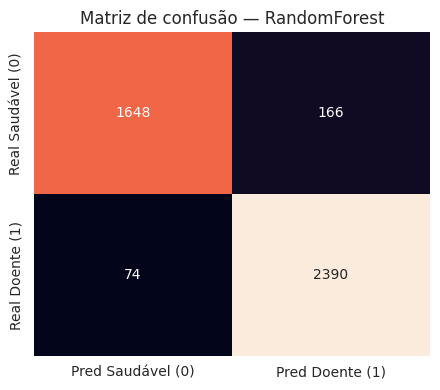

In [150]:
# Modelo principal com RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# vamos usar os mesmos dados numéricos do baseline
X_train_num = X_train.select_dtypes(include=["int64", "float64"]).copy()
X_test_num  = X_test.select_dtypes(include=["int64", "float64"]).copy()

rf = RandomForestClassifier(
    n_estimators=50,
    random_state=2,
    n_jobs=-1,
    class_weight=None  # podemos ligar depois se quiser priorizar ainda mais a classe 1
)
rf.fit(X_train_num, y_train)

# predições
y_pred_rf = rf.predict(X_test_num)
y_prob_rf = rf.predict_proba(X_test_num)[:, 1]

# métricas
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

print(f"Acurácia (teste) – RF: {acc_rf:.4f}")
print(f"ROC-AUC  (teste) – RF: {auc_rf:.4f}\n")

print("Classification report – RF:")
print(classification_report(
    y_test,
    y_pred_rf,
    target_names=["Saudável (0)", "Doente (1)"],
    digits=4
))

# matriz de confusão
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[0, 1])
cm_rf_df = pd.DataFrame(cm_rf, index=["Real Saudável (0)", "Real Doente (1)"], columns=["Pred Saudável (0)", "Pred Doente (1)"])

plt.figure(figsize=(4.5, 4))
sns.heatmap(cm_rf_df, annot=True, fmt="d", cbar=False)
plt.title("Matriz de confusão — RandomForest")
plt.tight_layout()
plt.show()


**Análise do modelo**

O modelo de Random Forest apresentou desempenho superior ao baseline em termos de sensibilidade para a classe Doente (1). O recall subiu para 97%, reduzindo o número de falsos negativos de 124 (árvore) para 74 exames. Isso vai ao encontro do objetivo definido na introdução, que era priorizar a identificação de exames potencialmente patológicos. Em contrapartida, houve um aumento no número de falsos positivos (166 casos), o que indica que o modelo ficou mais conservador e passou a classificar mais exames como “doente”. Como se trata de um cenário de apoio à triagem, esse comportamento é aceitável. Além disso, o ROC-AUC de 0,9868 mostra que a Random Forest separa melhor as duas classes do que a árvore individual.

### 5.4 – Importância das features

Para entender quais variáveis mais contribuíram para as previsões, vamos extrair as importâncias da Random Forest treinada na etapa anterior. Como nosso dataset tem centenas de features numéricas vindas do 12SL, vamos listar apenas as mais relevantes. Esse tipo de análise não substitui uma interpretação clínica, mas ajuda a mostrar que o modelo está usando majoritariamente informações do sinal de ECG (e não colunas administrativas).

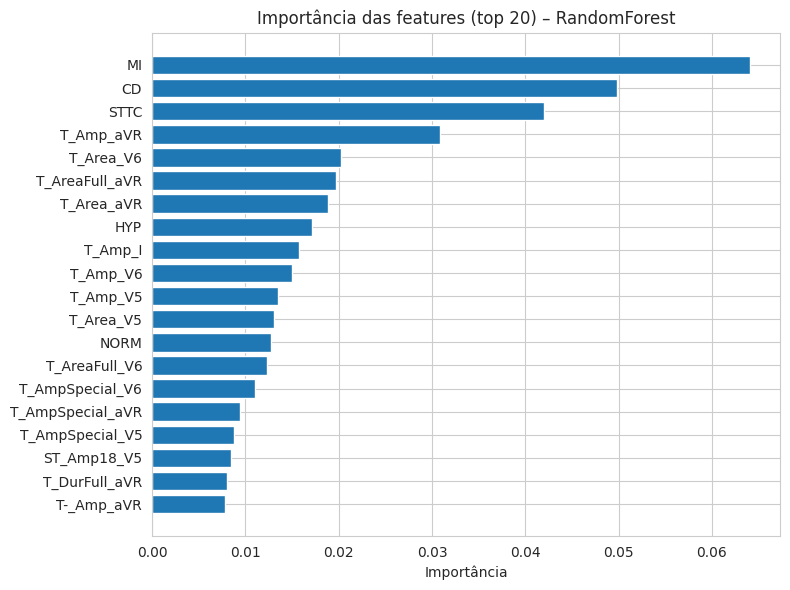

In [154]:
# Importância de features da Random Forest

import pandas as pd
import matplotlib.pyplot as plt

# usamos o mesmo X_train_num que foi usado para treinar a RF
feature_names = X_train_num.columns
importances = rf.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# mostrar as 20 mais importantes
top_n = 20
fi_top = fi_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(fi_top["feature"][::-1], fi_top["importance"][::-1])
plt.title("Importância das features (top 20) – RandomForest")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()


**Observações sobre a importância das features**

* As três features mais importantes para a Random Forest foram justamente as colunas de superclasse que criamos (MI, CD, STTC). Isso mostra que o modelo está usando fortemente a informação clínica derivada do mapeamento de diagnósticos que fizemos na etapa 3.2.

* Em seguida aparecem as medidas extraídas do ECG (principalmente amplitudes e áreas do segmento T em diferentes derivações, como T_Amp_aVR, T_Area_V6, T_AreaFull_aVR). Isso indica que o modelo também está capturando sinal diretamente das features do 12SL, e não apenas do diagnóstico agregado.

* A presença de NORM entre as 15 mais importantes reforça que a separação saudável vs. patológico ficou bem marcada no dataset.

* Como as colunas de superclasse são muito fortes, uma possível evolução seria testar um modelo sem essas colunas para ver quanto do desempenho vem só das features do traçado. Isso ajuda a mostrar que o modelo não está “só repetindo” o laudo.

# 6 - Conclusão

Este projeto demonstrou com sucesso a viabilidade de construir um modelo de Machine Learning para a triagem automática de exames de ECG. O modelo Random Forest apresentou um desempenho robusto, com alta acurácia e, crucialmente, alto recall para a identificação de pacientes com potenciais anormalidades. A interpretabilidade do modelo, evidenciada pela análise de features, alinha-se com o conhecimento clínico, aumentando a confiança na solução.

Como sistema de apoio à decisão, este modelo pode ser integrado ao fluxo de trabalho do hospital para priorizar exames para revisão humana, otimizando o tempo da equipe médica e potencialmente acelerando o diagnóstico. É importante salientar que, neste estudo, foi utilizada uma combinação do dataset ptbxl (base) com o 12SL, sendo este último proprietário.